## Homework 3 ICA_oop: rewritten from Lecture 03_ICA.jpynb

In [1]:
from re import X
from unittest import signals
import numpy as np

class FastICA:
    def __init__(self, alpha = 1, thresh=1e-8, iterations=5000):
        self.alpha = alpha
        self.thresh = thresh
        self.iterations = iterations
        self.mean = None
        self.Xw = None
        self.W = None
        
    def center(self, X):
        mean = np.mean(X, axis=1, keepdims=True)
        self.mean = mean
        centered =  X - mean 
        return centered, self.mean
        

    def covariance(self, X):
        mean = np.mean(X, axis=1, keepdims=True)
        n = np.shape(X)[1] - 1
        m = X - mean

        return (m.dot(m.T))/n

    def whiten(self, X):
        coVarM = FastICA.covariance(self,X) 
        
        U, S, V = np.linalg.svd(coVarM)
    
        d = np.diag(1.0 / np.sqrt(S)) 
        
        whiteM= np.dot(d, U.T)  
        self.Xw = np.dot(whiteM, X) 
    
        return self.Xw, whiteM
    
    def fit(self, X):
        # Center signals
        Xc, meanX = FastICA.center(self,X)
        # Whiten mixed signals
        Xw, whiteM = FastICA.whiten(self,Xc)
        signals = self.Xw
        
        # Initialize random weights
        
        m, n = signals.shape
    
        self.W = np.random.rand(m, m)

        for c in range(m):
            w = self.W[c, :].copy().reshape(m, 1)
            w = w / np.sqrt((w ** 2).sum())

            i = 0
            lim = 100
            while ((lim > self.thresh) & (i < self.iterations)):

                # Dot product of weight and signal
                ws = np.dot(w.T, signals)

                # Pass w*s into contrast function g
                wg = np.tanh(ws * self.alpha).T

                # Pass w*s into g prime 
                wg_ = (1 - np.square(np.tanh(ws))) * self.alpha

                # Update weights
                wNew = (signals * wg.T).mean(axis=1) - wg_.mean() * w.squeeze()

                # Decorrelate weights              
                wNew = wNew - np.dot(np.dot(wNew, self.W[:c].T), self.W[:c])
                wNew = wNew / np.sqrt((wNew ** 2).sum())

                # Calculate limit condition
                lim = np.abs(np.abs((wNew * w).sum()) - 1)
                
                # Update weights
                w = wNew
                
                # Update counter
                i += 1

            self.W[c, :] = w.T
            print(c, self.W[c, :])
        return self.W


    def unmix(self):
        # #Un-mix signals 
   
        return self.W.dot(self.Xw)


In [2]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Enable plots inside the Jupyter NotebookLet the
%matplotlib inline

In [3]:
# Set a seed for the random number generator for reproducibility
np.random.seed(23)
# Number of samples
ns = np.linspace(0, 200, 1000)
# Source matrix
S = np.array([np.sin(ns * 1), 
              signal.sawtooth(ns * 1.9),
              np.random.random(len(ns))]).T
S = S.T
# Mixing matrix
A = np.array([[0.5, 1, 0.2], 
              [1, 0.5, 0.4], 
              [0.5, 0.8, 1]])
# Mixed signal matrix
# X = S.dot(A).T
X = A.dot(S)
print(ns.shape, S.shape, A.shape, X.shape)

(1000,) (3, 1000) (3, 3) (3, 1000)


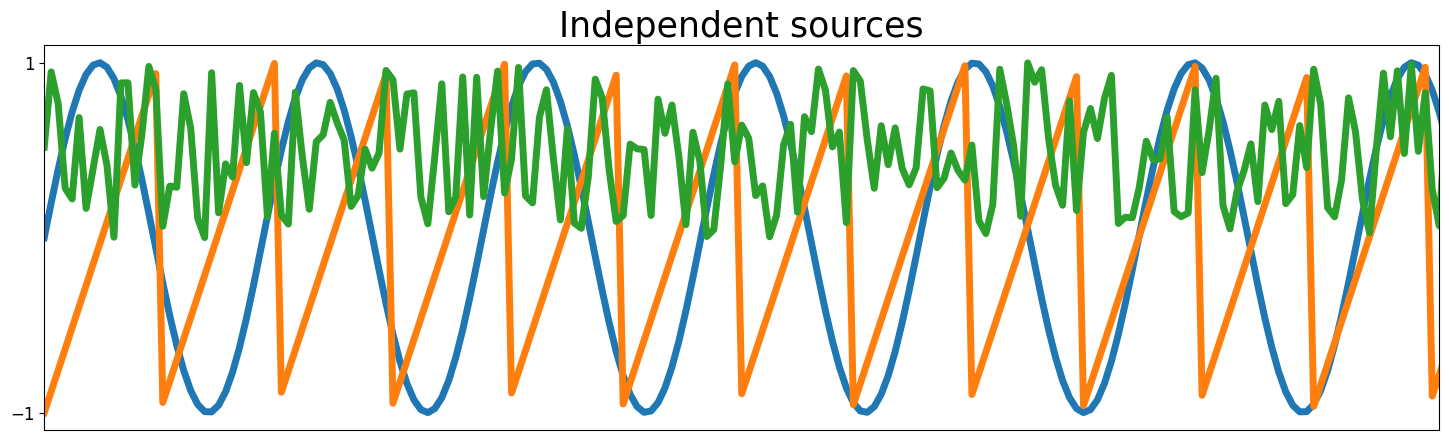

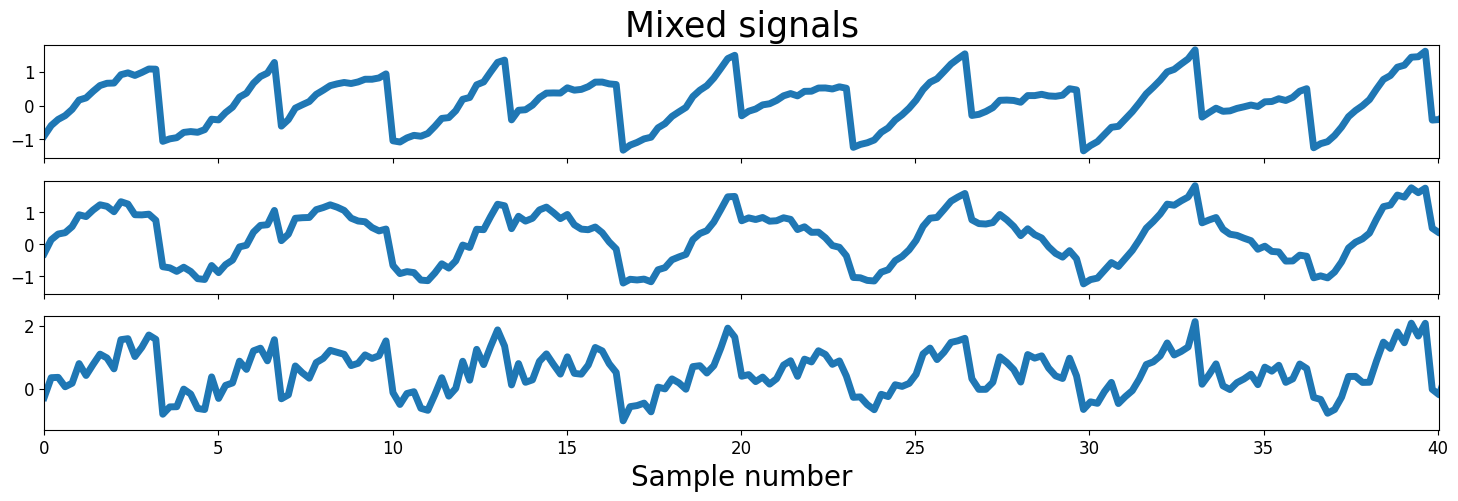

In [4]:
# Plot sources & signals
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(ns, S.T, lw=5)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_xlim(ns[0], ns[200])
ax.tick_params(labelsize=12)
ax.set_title('Independent sources', fontsize=25)

fig, ax = plt.subplots(3, 1, figsize=[18, 5], sharex=True)
ax[0].plot(ns, X[0], lw=5)
ax[0].set_title('Mixed signals', fontsize=25)
ax[0].tick_params(labelsize=12)

ax[1].plot(ns, X[1], lw=5)
ax[1].tick_params(labelsize=12)
ax[1].set_xlim(ns[0], ns[-1])

ax[2].plot(ns, X[2], lw=5)
ax[2].tick_params(labelsize=12)
ax[2].set_xlim(ns[0], ns[-1])
ax[2].set_xlabel('Sample number', fontsize=20)
ax[2].set_xlim(ns[0], ns[200])

plt.show()

In [5]:
fastica = FastICA(alpha=1, thresh=1e-8, iterations=5000)
W = fastica.fit(X)
unMixed = fastica.unmix()
print(unMixed.shape)

0 [0.71556572 0.69237332 0.09265467]
1 [-0.23231781  0.11078639  0.96630989]
2 [ 0.65878231 -0.71298356  0.24012559]
(3, 1000)


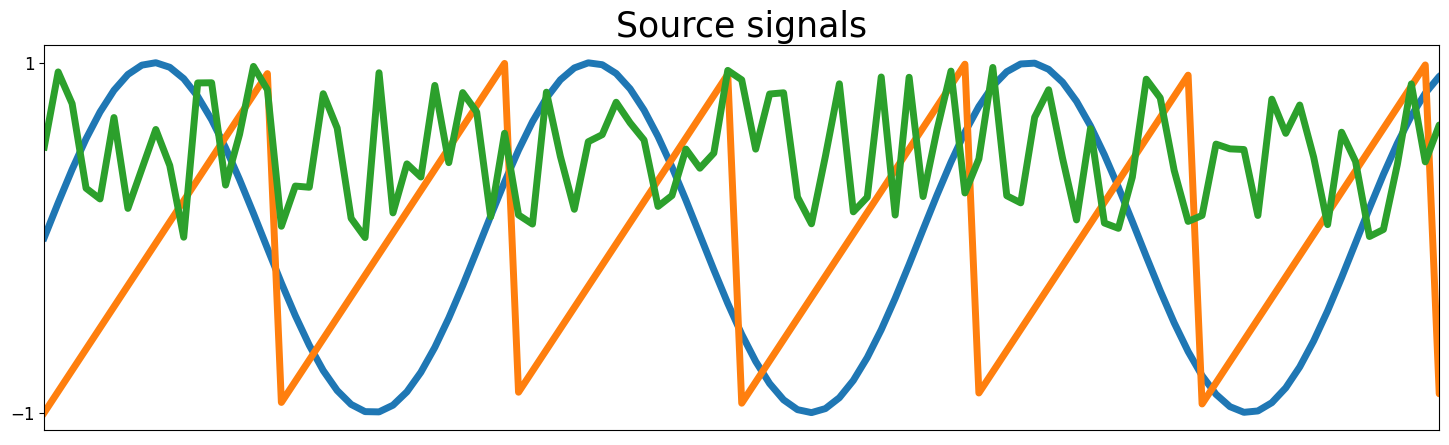

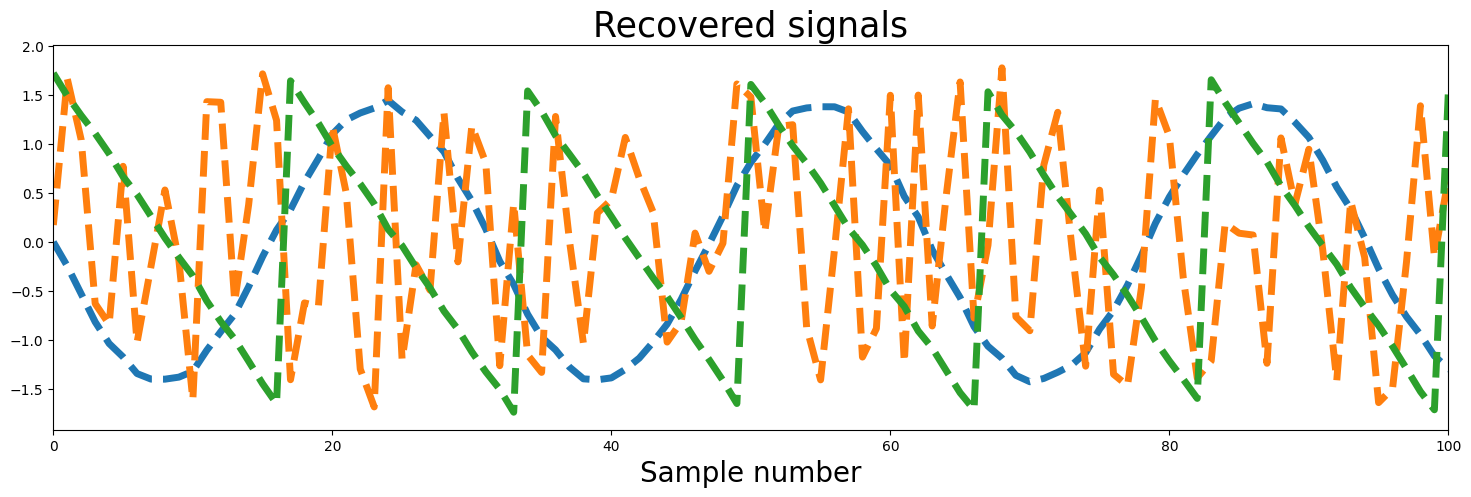

In [6]:
# Plot input signals (not mixed)
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(S.T, lw=5)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Source signals', fontsize=25)
ax.set_xlim(0, 100)

fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(unMixed.T, '--', label='Recovered signals', lw=5)
ax.set_xlabel('Sample number', fontsize=20)
ax.set_title('Recovered signals', fontsize=25)
ax.set_xlim(0, 100)

plt.show()

In [7]:


def kurt(x):
    n = np.shape(x)[0]
    mean = np.sum((x**1)/n) # Calculate the mean
    var = np.sum((x-mean)**2)/n # Calculate the variance
    skew = np.sum((x-mean)**3)/n # Calculate the skewness
    kurt = np.sum((x-mean)**4)/n # Calculate the kurtosis
    kurt = kurt/(var**2)-3

    return kurt, skew, var, mean

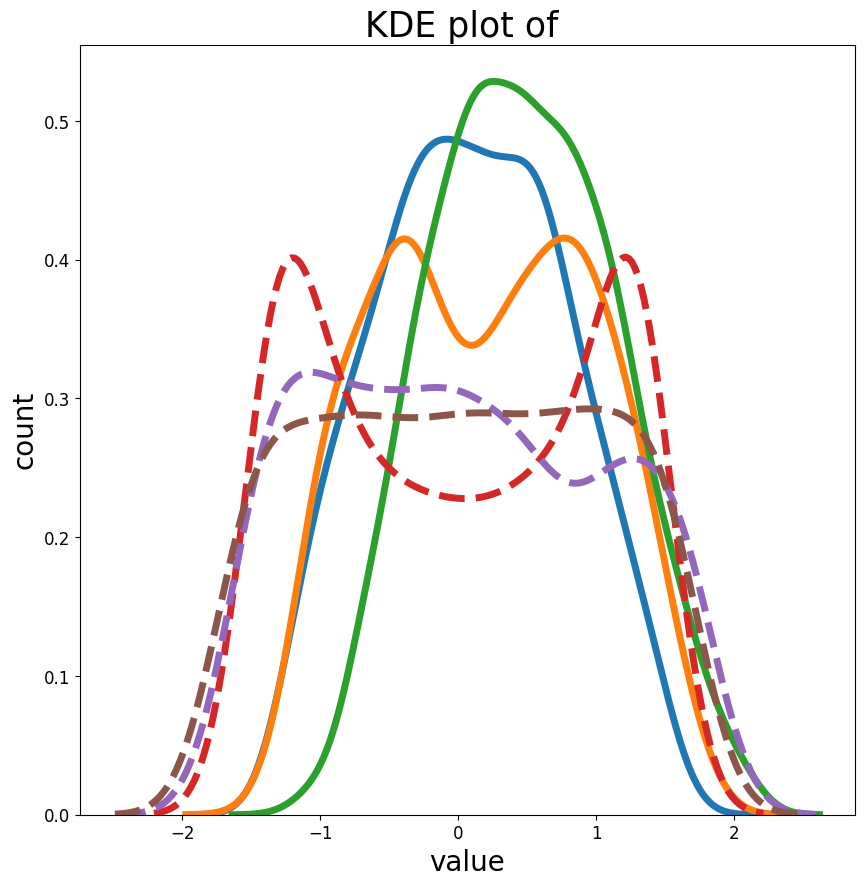

In [8]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i in range(X.shape[0]):
    
    sns.kdeplot(X[i, :], lw=5, label='Mixed Kurtosis={}'.format(np.round(kurt(X[i, :])[0], decimals=1)))
    
for i in range(X.shape[0]):   
    sns.kdeplot(unMixed[i, :], lw=5, ls='--', label='unMixed Kurtosis={}'.format(np.around(kurt(unMixed[i, :])[0], decimals=1)))

ax.tick_params(labelsize=12)
ax.set_xlabel('value', fontsize=20)
ax.set_ylabel('count', fontsize=20)
ax.set_title('KDE plot of ', fontsize=25)
plt.show()